In [1]:
# ! pip install gymnasium==0.29.1
# ! pip install pybullet

In [2]:
# ! pip install stable-baselines3\[extra\]

## Create the Navigation Environment (BARN-like 2D Maze + LiDAR)

new

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
import pandas as pd
import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.logger import configure

import imageio
import random

pybullet build time: Nov 23 2025 14:54:14


In [2]:
class AutoPipetteEnv(gym.Env):

    metadata = {"render_modes": []}

    def __init__(
        self,
        render_mode=None,
        world_size=10.0,          # half-extent of square world (meters)
        start=None,               # (x, y) in meters; if None, fixed default
        goal=None,                # (x, y) in meters; if None, fixed default
        num_obstacles=15,
        obstacle_size=0.6,        # half-size of obstacle footprint (meters)
        obstacle_height=2.0,      # obstacle half-height (meters)
        wall_thickness=0.1,       # half-thickness of boundary walls (meters)
        wall_height=2.0,          # wall half-height (meters)
        lidar_rays=72,
        lidar_range=10.0,         # max LiDAR distance (meters)
        lidar_height=0.2,         # LiDAR z-height (meters)
        robot_radius=0.4,         # used for safe sampling / proximity (meters)
        dt=0.2,                   # integration timestep (seconds)
        v_limits=(-0.7, 1.0),     # min/max linear velocity (m/s)
        w_limits=(-1.5, 1.5),     # min/max angular velocity (rad/s)
        goal_radius=0.8,          # shaping radius + goal half-size in XY (meters)
        goal_height=2.0,          # visible goal box half-height (meters)
        max_episode_steps=500,
        seed=None,
    ):
        super().__init__()

        # ---------------- Core config ----------------
        self.render_mode = render_mode
        self.world = float(world_size)
        self.num_obstacles = int(num_obstacles)

        self.obstacle_size = float(obstacle_size)
        self.obstacle_height = float(obstacle_height)

        self.wall_thickness = float(wall_thickness)
        self.wall_height = float(wall_height)

        self.lidar_rays = int(lidar_rays)
        self.lidar_range = float(lidar_range)
        self.lidar_height = float(lidar_height)

        self.robot_radius = float(robot_radius)
        self.dt = float(dt)
        self.v_min, self.v_max = map(float, v_limits)
        self.w_min, self.w_max = map(float, w_limits)

        # goal_radius is used both for shaping and as half-size of goal box in XY
        self.goal_radius = float(goal_radius)
        self.goal_height = float(goal_height)

        self.max_steps = int(max_episode_steps)

        # World bounds (square)
        self.x_min, self.x_max = -self.world, self.world
        self.y_min, self.y_max = -self.world, self.world

        # max possible distance between robot and goal (diagonal of world)
        self.max_goal_dist = float(
            np.linalg.norm([self.x_max - self.x_min, self.y_max - self.y_min])
        )

        # Start / goal positions
        default_start = (0.0, 7.5)
        default_goal = (-3.0, -5.0)
        self.start = np.array(
            start if start is not None else default_start, dtype=float
        )
        self.goal = np.array(
            goal if goal is not None else default_goal, dtype=float
        )

        # RNG
        self.np_random, _ = seeding.np_random(seed)

        # ---------------- PyBullet setup ----------------
        if p.isConnected():
            p.disconnect()
        p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # ---------------- Action / observation spaces ----------------
        self.action_space = spaces.Box(
            low=np.array([self.v_min, self.w_min], dtype=np.float32),
            high=np.array([self.v_max, self.w_max], dtype=np.float32),
            dtype=np.float32,
        )

        obs_low = np.concatenate(
            [
                np.zeros(self.lidar_rays, dtype=np.float32),      # LiDAR in [0, 1]
                np.array([0.0, -1.0], dtype=np.float32),          # norm dist, norm angle
            ]
        )
        obs_high = np.concatenate(
            [
                np.ones(self.lidar_rays, dtype=np.float32),       # LiDAR in [0, 1]
                np.array([1.0, 1.0], dtype=np.float32),           # norm dist, norm angle
            ]
        )

        self.observation_space = spaces.Box(
            low=obs_low,
            high=obs_high,
            dtype=np.float32,
        )

        # ---------------- State ----------------
        self.robot_pos = None      # np.array([x, y])
        self.robot_yaw = None      # float (rad)
        self.prev_dist = None
        self.step_count = 0

        # ---------------- Bookkeeping for PyBullet ----------------
        self.plane_id = None
        self.wall_ids = []
        self.obstacle_ids = []
        self.goal_id = None
        self.last_lidar_ids = [None] * self.lidar_rays

        # ---------------- Reward weights (named, tunable) ----------------
        self.reward_progress_scale = 4.0          # weight for progress term
        self.reward_goal_attraction = 3.0         # always encourages being closer
        self.reward_free_space_scale = 0.5        # prefer open space
        self.reward_final_approach_scale = 5.0    # shaping when close to goal
        self.reward_proximity_scale = 8.0         # penalty for being near obstacles
        self.reward_turn_smoothness = 0.01        # penalize large w
        self.reward_forward_smoothness = 0.003    # prefer moving forward
        self.reward_step_cost = 0.001             # tiny step penalty
        self.reward_collision_penalty = 80.0      # big negative on collision
        self.reward_success_bonus = 300.0         # big positive on success

        # Proximity thresholds (for LiDAR)
        self.proximity_safe = 1.0          # start penalizing below this (meters)
        self.proximity_collision = 0.2     # collision threshold (meters)

    # ======================================================================
    # Helpers
    # ======================================================================
    @staticmethod
    def _wrap_angle(a: float) -> float:
        """Wrap angle to [-π, π]."""
        return (a + np.pi) % (2 * np.pi) - np.pi

    def _add_box(self, xy, half_extents):
        """
        Add an axis-aligned box resting on the ground (z = half_height).
        Returns PyBullet body id.
        """
        hx, hy, hz = map(float, half_extents)
        col = p.createCollisionShape(
            p.GEOM_BOX,
            halfExtents=[hx, hy, hz],
        )
        body_id = p.createMultiBody(
            baseCollisionShapeIndex=col,
            basePosition=[float(xy[0]), float(xy[1]), hz],  # bottom at z = 0
        )
        return body_id

    def _sample_free_position(self, min_clearance: float) -> np.ndarray:
        """
        Sample a 2D position in the world that is:
          - inside boundaries with a margin
          - not too close to start, goal or existing obstacles
        """
        margin = max(self.robot_radius, self.obstacle_size)
        while True:
            x = self.np_random.uniform(self.x_min + margin, self.x_max - margin)
            y = self.np_random.uniform(self.y_min + margin, self.y_max - margin)
            candidate = np.array([x, y], dtype=float)

            # distance to start & goal
            if np.linalg.norm(candidate - self.start) < min_clearance:
                continue
            if np.linalg.norm(candidate - self.goal) < min_clearance:
                continue

            # distance to existing obstacles
            too_close = False
            for oid in self.obstacle_ids:
                pos, _ = p.getBasePositionAndOrientation(oid)
                ox, oy = pos[:2]
                if np.linalg.norm(candidate - np.array([ox, oy])) < min_clearance:
                    too_close = True
                    break
            if not too_close:
                return candidate

    # ======================================================================
    # LiDAR + observation construction
    # ======================================================================
    def _lidar_scan(self) -> np.ndarray:
        """Cast lidar_rays around the robot and return raw distances (meters)."""
        angles = np.linspace(-np.pi, np.pi, self.lidar_rays, endpoint=False)
        dists = []
        body_ids = []

        sx, sy = self.robot_pos
        for ang in angles:
            start = [float(sx), float(sy), self.lidar_height]
            end = [
                sx + self.lidar_range * np.cos(self.robot_yaw + ang),
                sy + self.lidar_range * np.sin(self.robot_yaw + ang),
                self.lidar_height,
            ]

            hit = p.rayTest(start, end)[0]
            body = hit[0]
            frac = hit[2]

            if frac < 1.0:
                dists.append(self.lidar_range * frac)
                body_ids.append(body)
            else:
                dists.append(self.lidar_range)
                body_ids.append(None)

        self.last_lidar_ids = body_ids
        return np.array(dists, dtype=np.float32)

    def _goal_features(self):
        """Return (distance_to_goal, goal_angle_in_robot_frame)."""
        delta = self.goal - self.robot_pos
        dist = float(np.linalg.norm(delta))
        world_angle = np.arctan2(delta[1], delta[0])
        rel_angle = self._wrap_angle(world_angle - self.robot_yaw)
        return dist, rel_angle

    def _get_obs(self):
        """
        Returns:
            obs        : normalized observation (np.float32)
            dist       : raw distance to goal (meters)
            lidar_raw  : raw LiDAR distances (meters)
        """
        # -------- LiDAR --------
        lidar_raw = self._lidar_scan()

        # Ignore goal in LiDAR so it is not treated as obstacle
        cleaned_lidar = []
        for d, bid in zip(lidar_raw, self.last_lidar_ids):
            if bid == self.goal_id:
                cleaned_lidar.append(self.lidar_range)
            else:
                cleaned_lidar.append(d)
        cleaned_lidar = np.array(cleaned_lidar, dtype=np.float32)

        # -------- Goal features --------
        dist, ang = self._goal_features()

        # -------- Normalization --------
        lidar_norm = cleaned_lidar / self.lidar_range                 # [0, 1]
        goal_dist_norm = dist / self.max_goal_dist                    # [0, 1]
        goal_angle_norm = ang / np.pi                                 # [-1, 1]

        obs = np.concatenate(
            [
                lidar_norm.astype(np.float32),
                np.array([goal_dist_norm, goal_angle_norm], dtype=np.float32),
            ]
        )

        return obs.astype(np.float32), dist, lidar_raw

    # ======================================================================
    # Step
    # ======================================================================
    def step(self, action):
        # Clip action into allowed range
        v, w = np.clip(action, self.action_space.low, self.action_space.high)
        v = float(v)
        w = float(w)

        # -------- Kinematics --------
        self.robot_yaw += w * self.dt
        direction = np.array([np.cos(self.robot_yaw), np.sin(self.robot_yaw)], dtype=float)
        self.robot_pos += v * direction * self.dt

        # Out-of-bounds check
        out_of_bounds = not (
            self.x_min <= self.robot_pos[0] <= self.x_max
            and self.y_min <= self.robot_pos[1] <= self.y_max
        )

        # Observe environment after motion
        obs, dist, lidar_raw = self._get_obs()

        # Effective obstacle distances (ignore plane & goal)
        effective_dists = []
        for d, bid in zip(lidar_raw, self.last_lidar_ids):
            if bid is None:
                continue
            if bid == self.plane_id:
                continue
            if bid == self.goal_id:
                continue           # goal is not an obstacle
            if bid in self.wall_ids or bid in self.obstacle_ids:
                effective_dists.append(d)

        min_lidar = min(effective_dists) if effective_dists else self.lidar_range

        # Free space metric (0–1): larger when more open
        free_space = float(np.mean(lidar_raw / self.lidar_range))

        # -------- Termination flags (used in reward) --------
        collision = (min_lidar < self.proximity_collision) or out_of_bounds

        gx, gy = self.goal
        half_goal = self.goal_radius
        inside_goal = (
            (gx - half_goal <= self.robot_pos[0] <= gx + half_goal)
            and (gy - half_goal <= self.robot_pos[1] <= gy + half_goal)
        )
        success = inside_goal

        # -------- Reward --------
        reward = 0.0

        # 1) Progress toward goal (only positive)
        progress = self.prev_dist - dist
        if progress > 0.0:
            reward += self.reward_progress_scale * progress

        # 2) Attraction to goal (larger when closer)
        reward += self.reward_goal_attraction / (1.0 + dist)

        # 3) Prefer open free space
        reward += self.reward_free_space_scale * free_space

        # 4) Extra shaping when within goal_radius
        if dist < self.goal_radius:
            reward += self.reward_final_approach_scale * (self.goal_radius - dist)

        # 5) Penalty for being close to obstacles/walls
        if min_lidar < self.proximity_safe:
            reward -= self.reward_proximity_scale * (self.proximity_safe - min_lidar)

        # 6) Smoothness: penalize rotations and discourage going backwards
        reward -= self.reward_turn_smoothness * (w ** 2)
        reward -= self.reward_forward_smoothness * (1.0 - v)  # encourages v ≈ 1.0

        # 7) Small step cost
        reward -= self.reward_step_cost

        # 8) Terminal bonuses/penalties
        if collision:
            reward -= self.reward_collision_penalty
        if success:
            reward += self.reward_success_bonus

        # -------- Final bookkeeping --------
        terminated = collision or success
        truncated = (self.step_count >= self.max_steps)

        self.step_count += 1
        self.prev_dist = dist

        info = {
            "collision": collision,
            "success": success,
            "distance_to_goal": dist,
            "progress": progress,
            "min_lidar": min_lidar,
            "out_of_bounds": out_of_bounds,
        }

        return obs, float(reward), terminated, truncated, info

    # ======================================================================
    # Reset
    # ======================================================================
    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = seeding.np_random(seed)

        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.plane_id = p.loadURDF("plane.urdf")

        self.wall_ids = []
        self.obstacle_ids = []
        self.goal_id = None

        # --- Walls (simple box segments) ---
        self.wall_ids.append(
            self._add_box(
                (self.x_min, 0.0),
                [self.wall_thickness, self.world, self.wall_height],
            )
        )
        self.wall_ids.append(
            self._add_box(
                (self.x_max, 0.0),
                [self.wall_thickness, self.world, self.wall_height],
            )
        )
        self.wall_ids.append(
            self._add_box(
                (0.0, self.y_min),
                [self.world, self.wall_thickness, self.wall_height],
            )
        )
        self.wall_ids.append(
            self._add_box(
                (0.0, self.y_max),
                [self.world, self.wall_thickness, self.wall_height],
            )
        )

        # --- Obstacles ---
        min_clearance = self.robot_radius + self.obstacle_size + 0.3
        for _ in range(self.num_obstacles):
            pos = self._sample_free_position(min_clearance=min_clearance)
            oid = self._add_box(
                pos,
                [self.obstacle_size, self.obstacle_size, self.obstacle_height],
            )
            self.obstacle_ids.append(oid)

        # --- Goal cube (visible, LiDAR-hittable) ---
        self.goal_id = self._add_box(
            self.goal,
            [self.goal_radius, self.goal_radius, self.goal_height],
        )

        # --- Robot state ---
        self.robot_pos = self.start.copy()
        self.robot_yaw = -np.pi / 2.0          # facing "down" initially
        self.step_count = 0
        self.prev_dist = float(np.linalg.norm(self.robot_pos - self.goal))

        obs, _, _ = self._get_obs()
        return obs, {}

    # ======================================================================
    # Close
    # ======================================================================
    def close(self):
        if p.isConnected():
            p.disconnect()


plot the env with LiDAR rays

In [5]:
def plot_environment_with_lidar(env, show=True):
    obs, dist, lidar = env._get_obs()

    robot_x, robot_y = env.robot_pos
    yaw = env.robot_yaw
    angles = np.linspace(-np.pi, np.pi, env.lidar_rays, endpoint=False)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_aspect("equal")

    # LIDAR rays
    for d, ang in zip(lidar, angles):
        end_x = robot_x + d * np.cos(yaw + ang)
        end_y = robot_y + d * np.sin(yaw + ang)
        ax.plot([robot_x, end_x], [robot_y, end_y],
                color="orange", alpha=0.25, linewidth=1, clip_on=False)

    # World boundary
    ax.plot(
        [env.x_min, env.x_max, env.x_max, env.x_min, env.x_min],
        [env.y_min, env.y_min, env.y_max, env.y_max, env.y_min],
        "k-", linewidth=2
    )

    # Obstacles
    for oid in env.obstacle_ids:
        pos, _ = p.getBasePositionAndOrientation(oid)
        x, y, z = pos
        s = env.obstacle_size
        ax.add_patch(plt.Rectangle((x - s, y - s), 2*s, 2*s, color="gray", alpha=0.6))

    # Goal
    gx, gy = env.goal
    gs = env.obstacle_size
    ax.add_patch(plt.Rectangle((gx - gs, gy - gs), 2*gs, 2*gs, color="cyan", alpha=0.6))

    # Robot
    ax.scatter(robot_x, robot_y, s=200, color="red", edgecolors="black")

    # Start
    ax.scatter(env.start[0], env.start[1], s=200, color="green", edgecolors="black")

    ax.set_title("AutoPipetteEnv – LiDAR Visualization")
    ax.grid(True, linestyle="--", alpha=0.4)

    pad = max(env.x_max - env.x_min, env.y_max - env.y_min) * 0.03
    ax.set_xlim(env.x_min - pad, env.x_max + pad)
    ax.set_ylim(env.y_min - pad, env.y_max + pad)

    if show:
        plt.show()

    return None


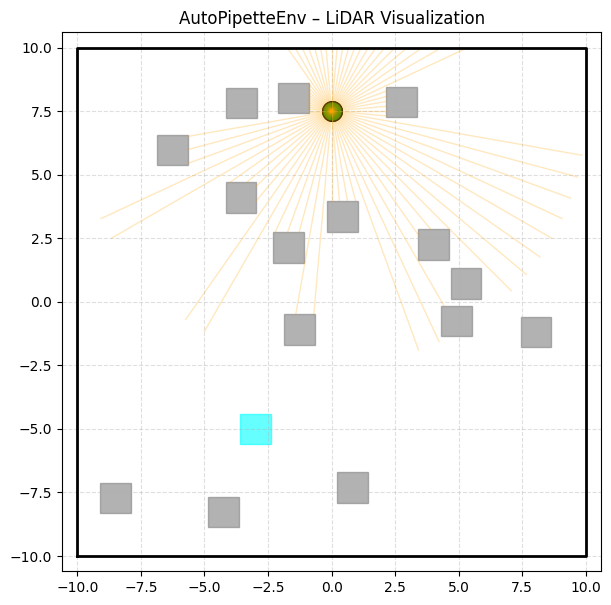

In [6]:
env = AutoPipetteEnv(seed  = 19)
obs, info = env.reset()

plot_environment_with_lidar(env)

Sanity Test Script (Copy & Run)

In [36]:
# def plot_environment_with_lidar(env):
#     """
#     Visualize AutoPipetteEnv:
#         - walls
#         - obstacles
#         - goal
#         - robot
#         - LiDAR rays (fully visible, not clipped)
#     """
#     obs, dist, lidar = env._get_obs()

#     robot_x, robot_y = env.robot_pos
#     yaw = env.robot_yaw

#     # Ray angles
#     angles = np.linspace(-np.pi, np.pi, env.lidar_rays, endpoint=False)

#     fig, ax = plt.subplots(figsize=(7, 7))
#     ax.set_aspect("equal")

#     # ---------------------------------------------------
#     # -------- LiDAR rays FIRST (no clipping) -----------
#     # ---------------------------------------------------
#     for d, ang in zip(lidar, angles):
#         end_x = robot_x + d * np.cos(yaw + ang)
#         end_y = robot_y + d * np.sin(yaw + ang)
#         ax.plot(
#             [robot_x, end_x], [robot_y, end_y],
#             color="orange", alpha=0.25, linewidth=1,
#             clip_on=False
#         )

#     # -------- World boundary --------
#     ax.plot(
#         [env.x_min, env.x_max, env.x_max, env.x_min, env.x_min],
#         [env.y_min, env.y_min, env.y_max, env.y_max, env.y_min],
#         "k-", linewidth=2, label="Walls"
#     )

#     # -------- Obstacles --------
#     for oid in env.obstacle_ids:
#         pos, _ = p.getBasePositionAndOrientation(oid)
#         x, y, z = pos
#         s = env.obstacle_size
#         ax.add_patch(
#             plt.Rectangle(
#                 (x - s, y - s), 2*s, 2*s,
#                 color="gray", alpha=0.6
#             )
#         )

#     # -------- Goal --------
#     gx, gy = env.goal
#     gs = env.obstacle_size
#     ax.add_patch(
#         plt.Rectangle(
#             (gx - gs, gy - gs), 2*gs, 2*gs,
#             color="cyan", alpha=0.6, label="Goal"
#         )
#     )

#     # -------- Robot --------
#     ax.scatter(robot_x, robot_y,
#                s=200, color="red", edgecolors="black", label="Robot")

#     # -------- Start --------
#     ax.scatter(env.start[0], env.start[1],
#                s=200, color="green", edgecolors="black", label="Start")

#     # ---------------------------------------------------
#     # -------- Expand axes to include LiDAR range -------
#     # ---------------------------------------------------
#     lidar_max = np.max(lidar)

#     ax.set_xlim(env.x_min - lidar_max, env.x_max + lidar_max)
#     ax.set_ylim(env.y_min - lidar_max, env.y_max + lidar_max)

#     # Formatting
#     ax.set_title("AutoPipetteEnv – LiDAR Visualization")
#     ax.grid(True, linestyle="--", alpha=0.4)
#     ax.legend()

#     plt.show()


full reactive controller

In [ ]:
def reactive_controller(env, steps=300, visualize_every=1, gif_name="run.gif", seed=0):

    # --------------------------------------------------
    # UNIVERSAL SEEDING
    # --------------------------------------------------
    np.random.seed(seed)
    random.seed(seed)

    # If env implements gym-style seeding:
    try:
        obs, info = env.reset(seed=seed)
    except TypeError:
        # backward compatibility
        obs, info = env.reset()
    # --------------------------------------------------

    # PyBullet seeding (optional but good practice)
    try:
        p.setPhysicsEngineParameter(deterministicOverlappingPairs=1)
    except:
        pass

    path_x = [env.robot_pos[0]]
    path_y = [env.robot_pos[1]]

    # Create folder for frames
    frame_dir = "_frames"
    os.makedirs(frame_dir, exist_ok=True)
    frame_paths = []

    # CONTROL PARAMETERS
    forward_speed = 1.0
    turn_rate = 3.0
    avoid_dist = 3.0
    escape_dist = 0.35
    goal_tol = 0.1
    angle_gain = 1.2

    lidar_rays = env.lidar_rays
    base_angles = np.linspace(-np.pi, np.pi, lidar_rays, endpoint=False)

    for step in range(steps):

        obs, dist, raw_lidar = env._get_obs()
        goal_dist  = obs[-2]
        goal_angle = obs[-1]

        # IGNORE GOAL IN LIDAR
        lidar = np.array([
            env.lidar_range if bid == env.goal_id else d
            for d, bid in zip(raw_lidar, env.last_lidar_ids)
        ])

        # SECTORS
        front_idx = np.where(np.abs(base_angles) < np.pi/6)[0]
        left_idx  = np.where((base_angles >  np.pi/6) & (base_angles < 2.0))[0]
        right_idx = np.where((base_angles < -np.pi/6) & (base_angles > -2.0))[0]

        min_front = np.min(lidar[front_idx])
        min_left  = np.min(lidar[left_idx])
        min_right = np.min(lidar[right_idx])

        # Default
        v = forward_speed
        w = 0.0

        # ESCAPE
        if min_front < escape_dist and min_left < escape_dist and min_right < escape_dist:
            v = -0.3
            w = turn_rate
        else:
            # OBSTACLE AVOIDANCE
            if min_front < avoid_dist:
                v = forward_speed * (min_front / avoid_dist)
                turn_strength = np.clip((avoid_dist - min_front) / avoid_dist, 0, 1)

                w = turn_rate * turn_strength if min_left > min_right else -turn_rate * turn_strength

            else:
                # GOAL SEEKING
                if abs(goal_angle) > goal_tol:
                    w = angle_gain * goal_angle

        # Step
        obs, reward, done, trunc, info = env.step(np.array([v, w]))

        path_x.append(env.robot_pos[0])
        path_y.append(env.robot_pos[1])

        # SAVE FRAME
        if step % visualize_every == 0:
            fig = plot_environment_with_lidar(env, show=False)
            frame_path = f"{frame_dir}/frame_{step:04d}.png"
            fig.savefig(frame_path, dpi=120, bbox_inches="tight")
            plt.close(fig)
            frame_paths.append(frame_path)

        if info["success"]:
            print(f"SUCCESS at step {step}")
            break

        if info["collision"]:
            print(f"COLLISION at step {step}")
            break

    # -------- MAKE GIF --------
    images = [imageio.imread(f) for f in frame_paths]
    imageio.mimsave(gif_name, images, fps=12)
    print(f"\nGIF saved as: {gif_name}")

    return path_x, path_y


In [ ]:
# seed = 4

# renv = AutoPipetteEnv(seed=seed)  # NEW env
# obs, info = env.reset()
# reactive_controller(env, steps=300, visualize_every=1, seed=seed)

In [ ]:
# def make_gif(frame_dir="_frames", gif_name="output.gif", fps=12):
#     """
#     Convert all PNG frames in a directory into a GIF.

#     Parameters:
#         frame_dir : str   - directory containing .png frames
#         gif_name  : str   - output gif filename
#         fps       : int   - animation speed
#     """
#     # Get all PNGs in sorted order
#     frame_files = sorted([
#         os.path.join(frame_dir, f)
#         for f in os.listdir(frame_dir)
#         if f.endswith(".png")
#     ])

#     if len(frame_files) == 0:
#         raise ValueError(f"No PNG frames found in {frame_dir}/")

#     print(f"Found {len(frame_files)} frames. Creating GIF...")

#     images = [imageio.imread(f) for f in frame_files]
#     imageio.mimsave(gif_name, images, fps=fps)

#     print(f"GIF saved as {gif_name}")

# make_gif("_frames", "15_obstacles_2.gif", fps=10)

hook into PPO and actually train an RL policy

In [40]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

In [41]:
# =========================================================
# 1. Paths & directories
# =========================================================
BASE_DIR   = "autopipette_results"
LOG_DIR    = os.path.join(BASE_DIR, "logs")
MODEL_DIR  = os.path.join(BASE_DIR, "models")
METRIC_DIR = os.path.join(BASE_DIR, "metrics")

for d in [BASE_DIR, LOG_DIR, MODEL_DIR, METRIC_DIR]:
    os.makedirs(d, exist_ok=True)

MODEL_PATH   = os.path.join(MODEL_DIR, "ppo_autopipette")
VECNORM_PATH = os.path.join(MODEL_DIR, "vecnorm_autopipette.pkl")
METRIC_PATH  = os.path.join(METRIC_DIR, "eval_metrics.json")

In [43]:
# =========================================================
# 2. Env factory (Monitor + VecNormalize ready)
# =========================================================
def make_env(seed: int = 0, log_dir: str = LOG_DIR):
    """
    Factory that creates ONE AutoPipetteEnv wrapped with Monitor.
    Used both for training and eval VecEnvs.
    """
    def _init():
        env = AutoPipetteEnv(seed=seed)
        # one monitor file per env index (SB3 appends .monitor.csv)
        log_file = os.path.join(log_dir, f"monitor_seed{seed}.csv")
        env = Monitor(env, filename=log_file)
        return env
    return _init


In [ ]:
N_ENVS          = 8
TOTAL_TIMESTEPS = 1_000_000

LOG_DIR = "autopipette_results_PPO/logs"
os.makedirs(LOG_DIR, exist_ok=True)

# --- create vectorized env for training ---
train_env = DummyVecEnv([make_env(seed=i) for i in range(N_ENVS)])

# normalize observations only (rewards left in original scale)
train_env = VecNormalize(
    train_env,
    norm_obs=True,
    norm_reward=False,
    clip_obs=10.0
)

model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=1e-4,
    n_steps=4096,
    batch_size=1024,
    ent_coef=0.02,
    gamma=0.995,
    n_epochs=20,
    clip_range=0.3,
    verbose=1,
)

# 👉 attach CSV logger so we can read progress.csv later
new_logger = configure(LOG_DIR, ["csv"])
model.set_logger(new_logger)

# --- train ---
model.learn(total_timesteps=TOTAL_TIMESTEPS)

# --- save model + normalization stats ---
model.save(MODEL_PATH)
train_env.save(VECNORM_PATH)
train_env.close()

print(f"✅ Model saved to      : {MODEL_PATH}.zip")
print(f"✅ VecNormalize saved to: {VECNORM_PATH}")
print(f"✅ Logs in: {LOG_DIR}")


Using cpu device
✅ Model saved to      : autopipette_results/models/ppo_autopipette.zip
✅ VecNormalize saved to: autopipette_results/models/vecnorm_autopipette.pkl
✅ Logs in: autopipette_results_PPO/logs


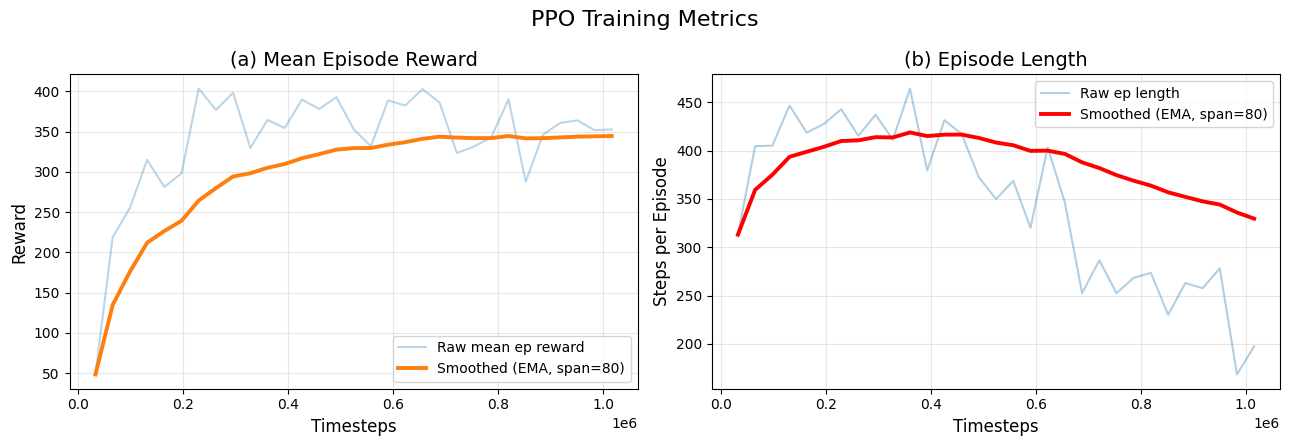

In [ ]:
def plot_reward_and_ep_length_side_by_side(log_dir, smooth_span=80):
    csv_path = os.path.join(log_dir, "progress.csv")
    df = pd.read_csv(csv_path)

    # Extract metrics
    timesteps = df["time/total_timesteps"]
    rewards   = df["rollout/ep_rew_mean"]
    ep_len    = df["rollout/ep_len_mean"]

    # Smooth curves
    rewards_smooth = rewards.ewm(span=smooth_span).mean()
    ep_len_smooth  = ep_len.ewm(span=smooth_span).mean()

    # --- FIGURE ---
    fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
    fig.suptitle("PPO Training Metrics", fontsize=16)

    # -------------------
    # (a) Reward Curve
    # -------------------
    axes[0].plot(timesteps, rewards, alpha=0.3, linewidth=1.5, label="Raw mean ep reward")
    axes[0].plot(timesteps, rewards_smooth, linewidth=2.8, label=f"Smoothed (EMA, span={smooth_span})")
    axes[0].set_title("(a) Mean Episode Reward", fontsize=14)
    axes[0].set_xlabel("Timesteps", fontsize=12)
    axes[0].set_ylabel("Reward", fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # -------------------
    # (b) Episode Length
    # -------------------
    axes[1].plot(timesteps, ep_len, alpha=0.35, linewidth=1.5, label="Raw ep length")
    axes[1].plot(timesteps, ep_len_smooth, linewidth=2.8, label=f"Smoothed (EMA, span={smooth_span})", color="red")
    axes[1].set_title("(b) Episode Length", fontsize=14)
    axes[1].set_xlabel("Timesteps", fontsize=12)
    axes[1].set_ylabel("Steps per Episode", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# call
LOG_DIR = "autopipette_results_PPO/logs"
plot_reward_and_ep_length_side_by_side(LOG_DIR, smooth_span=80)


presentation

In [ ]:
# def plot_env_snapshot_with_path(env, path_x, path_y, show=True):
#     """
#     Full environment visualization:
#       - walls
#       - obstacles
#       - goal
#       - start
#       - robot final position
#       - LiDAR rays
#       - entire executed path
#     """

#     # read lidar & orientation
#     obs, dist, lidar_raw = env._get_obs()
#     robot_x, robot_y = env.robot_pos
#     yaw = env.robot_yaw
#     angles = np.linspace(-np.pi, np.pi, env.lidar_rays, endpoint=False)

#     fig, ax = plt.subplots(figsize=(7.5, 7.5))
#     ax.set_aspect("equal")

#     # ---------------------------
#     #  PATH
#     # ---------------------------
#     ax.plot(path_x, path_y, '-o', color="blue",
#             markersize=2, linewidth=2, label="Executed Path")

#     # ---------------------------
#     #  LIDAR
#     # ---------------------------
#     for d, ang in zip(lidar_raw, angles):
#         end_x = robot_x + d * np.cos(yaw + ang)
#         end_y = robot_y + d * np.sin(yaw + ang)
#         ax.plot([robot_x, end_x], [robot_y, end_y],
#                 color="orange", alpha=0.22, linewidth=1, clip_on=False)

#     # ---------------------------
#     #  WORLD BOUNDARY
#     # ---------------------------
#     ax.plot(
#         [env.x_min, env.x_max, env.x_max, env.x_min, env.x_min],
#         [env.y_min, env.y_min, env.y_max, env.y_max, env.y_min],
#         "k-", linewidth=2, label="Walls"
#     )

#     # ---------------------------
#     #  OBSTACLES
#     # ---------------------------
#     for oid in env.obstacle_ids:
#         pos, _ = p.getBasePositionAndOrientation(oid)
#         x, y = pos[:2]
#         s = env.obstacle_size
#         ax.add_patch(
#             plt.Rectangle((x - s, y - s), 2*s, 2*s,
#                           color="gray", alpha=0.65)
#         )

#     # ---------------------------
#     #  GOAL (cyan square)
#     # ---------------------------
#     gx, gy = env.goal
#     g = env.goal_radius
#     ax.add_patch(
#         plt.Rectangle((gx - g, gy - g), 2*g, 2*g,
#                       color="cyan", alpha=0.6, label="Goal")
#     )

#     # ---------------------------
#     #  START (green)
#     # ---------------------------
#     ax.scatter(env.start[0], env.start[1],
#                s=200, color="green", edgecolors="black", label="Start")

#     # ---------------------------
#     #  ROBOT FINAL STATE (red)
#     # ---------------------------
#     ax.scatter(robot_x, robot_y,
#                s=300, color="red", edgecolors="black", label="Robot (final)")

#     # heading arrow
#     arrow_len = 1.2
#     ax.arrow(robot_x, robot_y,
#              arrow_len*np.cos(yaw), arrow_len*np.sin(yaw),
#              head_width=0.45, head_length=0.55, fc='red', ec='black')

#     # formatting
#     ax.set_title(f"Environment Snapshot (seeded run)")
#     ax.grid(True, linestyle="--", alpha=0.4)

#     pad = max(env.x_max - env.x_min, env.y_max - env.y_min) * 0.04
#     ax.set_xlim(env.x_min - pad, env.x_max + pad)
#     ax.set_ylim(env.y_min - pad, env.y_max + pad)

#     ax.legend(loc="upper right")

#     if show:
#         plt.show()

#     return fig

# seed = 1
# path_x, path_y = reactive_controller(env, seed=seed)
# plot_env_snapshot_with_path(env, path_x, path_y)
